In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from simulator_psc import Simulator
from tools_analysis import corrcoef, coef_var
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, set_style, despine, add_caption, regplot, scatterplot
import copy
from IPython.display import display
from collections import defaultdict
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import pathlib
from multiprocessing import  Pool

In [2]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

In [3]:
# p = pathlib.Path('../cluster/results/')
# path = pathlib.Path('../longrun_new/')
# path = pathlib.Path('../cluster/long_run_4000/')
# path = pathlib.Path('../results/')
path = pathlib.Path('/media/storage_ssd/causal_opto_data/results_10000/results_0/')

In [5]:
import json
with open(str(path / 'params_.json'), 'r') as f:
    params = json.load(f)

t_stop = params['status']['time']

In [6]:
conn = pd.read_feather(path / 'connections_0.feather')

In [7]:
sender_ids = conn.query('weight >= 0').source.sort_values().unique()

In [8]:
stim_data = np.load(path / 'stimulation_data_0.npz', allow_pickle=True)['data'][()]
stim_times = np.array(stim_data['times'])
stim_durations = np.array(stim_data['durations'])

In [15]:
stim_nodes = list(stim_data['stim_amps'].keys())

In [17]:
conn.loc[:,'source_stimulated'] = conn.source.isin(stim_nodes)
conn.loc[:,'target_stimulated'] = conn.target.isin(stim_nodes)
conn['stim_amp_source'] = conn.progress_apply(
    lambda x: stim_data['stim_amps'].get(x.source, 0), axis=1)

HBox(children=(IntProgress(value=0, max=1600000), HTML(value='')))

In [44]:
X = np.load(path / 'X_serial.npy')
Y = np.load(path / 'Y_serial.npy')
Z = np.load(path / 'Z_serial.npy')
Yb = np.load(path / 'Yb_serial.npy')

# look at all

In [12]:
N = 200
# query = 'stim_amp_source > 600 and stim_amp_source < 800 and weight > 0 and not target_stimulated and target_ex'
query = 'weight > 0 and not target_stimulated and target in @sender_ids and stim_amp_source > 1'
sample = conn.query(query)


In [13]:
sample.sort_values('stim_amp_source', ascending=False).head()

,weight,source,target,source_stimulated,target_stimulated,stim_amp_source
322552,0.124224,1681,781,True,False,10.0
674678,0.016991,220,222,True,False,10.0
989318,0.029958,1681,585,True,False,10.0
989319,0.019821,1681,861,True,False,10.0
989320,0.006953,1681,201,True,False,10.0


In [14]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

# sample = sample.sample(2000)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
len(sample)

1976

In [47]:
def process(row):
    z = Z[:,int(row.source) - 1]
    x = X[:,int(row.source) - 1]
    y = Y[:,int(row.target) - 1]
    yb = Yb[:,int(row.target) - 1]
    y_ref = y[z==1]
    yb_ref = yb[z==1]
    y_respons = y[x==1].mean()
    yb_respons = yb[x==1].mean()
    
    beta_iv = y_respons - y_ref.mean()
    correction = yb_respons - yb_ref.mean()
    beta_iv_did = beta_iv + correction
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y_respons - y[x==0].mean()
    beta = y_respons - np.random.choice(y[x==0], len(y_ref)).mean()
#     print(
#         len(y[z==1]), y[z==1].mean(), 
#         len(np.random.choice(y[x==0], int(sum(z)))), np.random.choice(y[x==0], int(sum(z))).mean())
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({
        'beta_iv': beta_iv, 
        'correction': correction,
        'beta_iv_did': beta_iv_did,
        'beta': beta, 
        'hit_rate': x.mean(), 
        'n_z': sum(z)
    })

In [48]:
process(sample.iloc[0,:])

beta              0.091264
beta_iv           0.129008
beta_iv_did       0.122376
correction       -0.006632
hit_rate          0.334078
n_z            4610.000000
dtype: float64

In [18]:
def parall_apply(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def apply(x): 
    return x.apply(process, axis=1, result_type="expand")

In [19]:
np.where(Z==1, X, X*0).sum(0)

array([0., 0., 0., ..., 0., 0., 0.])

(array([169., 765., 998., 707., 339., 165.,  42.,  11.,   3.,   1.]),
 array([ 536. , 1376.1, 2216.2, 3056.3, 3896.4, 4736.5, 5576.6, 6416.7,
        7256.8, 8096.9, 8937. ]),
 <a list of 10 Patch objects>)

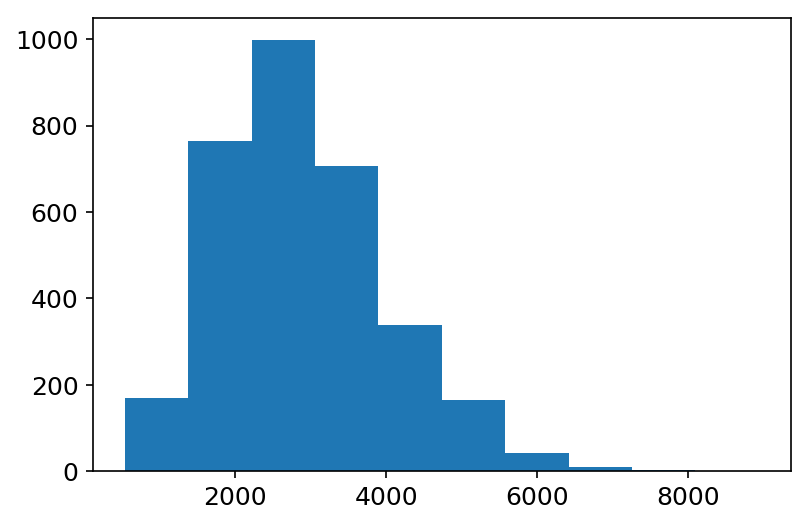

In [37]:
plt.hist(Z.sum(0))

In [49]:
# result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))
result = sample.join(parall_apply(sample, apply))

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

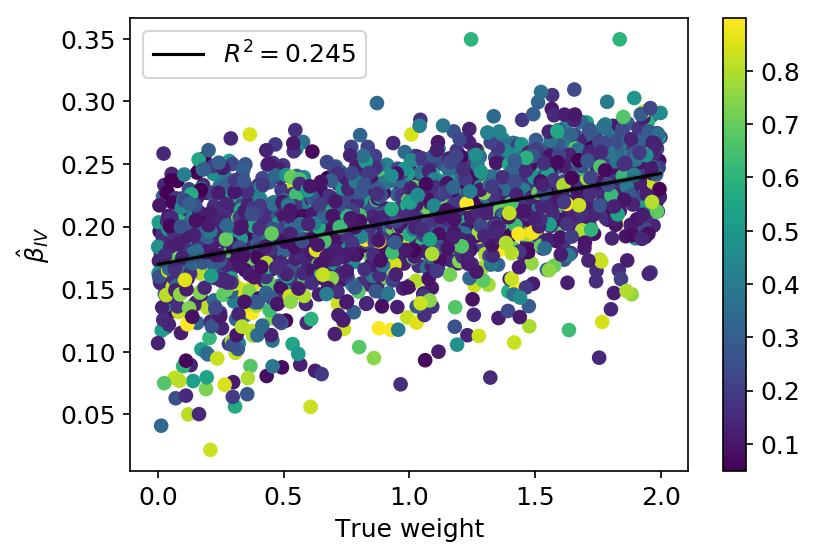

In [50]:
df_ = result#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

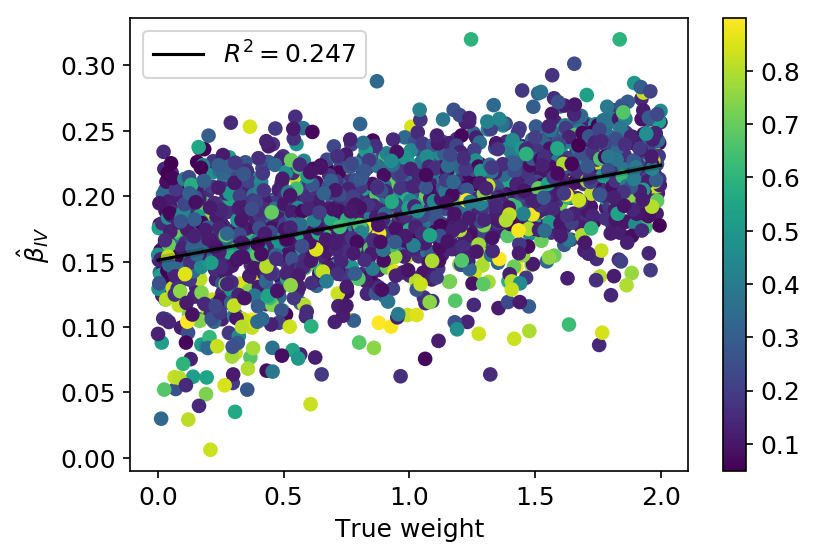

In [51]:
df_ = result#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'beta_iv_did', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

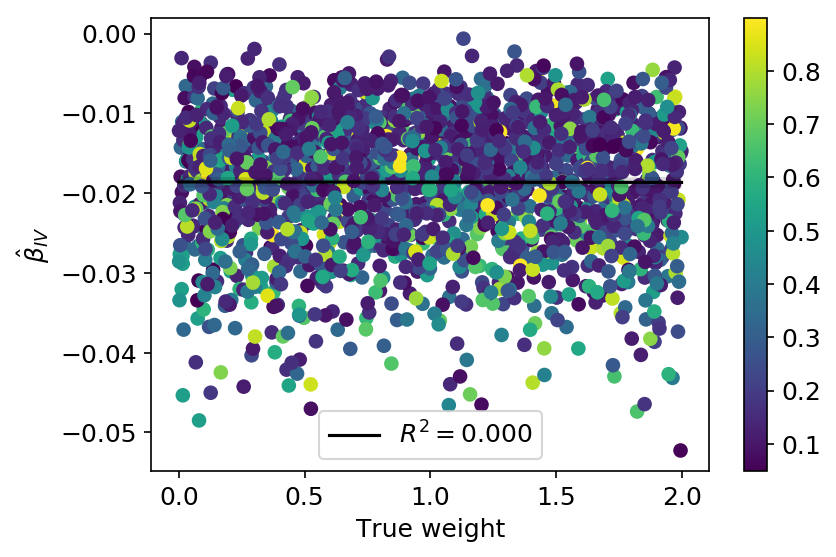

In [52]:
df_ = result#.query('hit_rate > 0.1 and hit_rate < .9')
model = regplot(
    'weight', 'correction', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

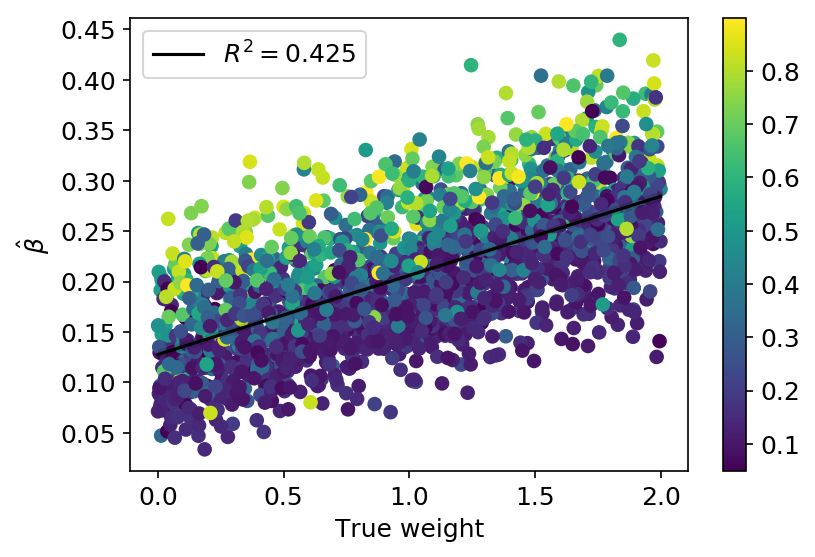

In [42]:
df_ = result#.query('hit_rate > .1 and hit_rate < .9')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'$\\hat{\\beta}$')

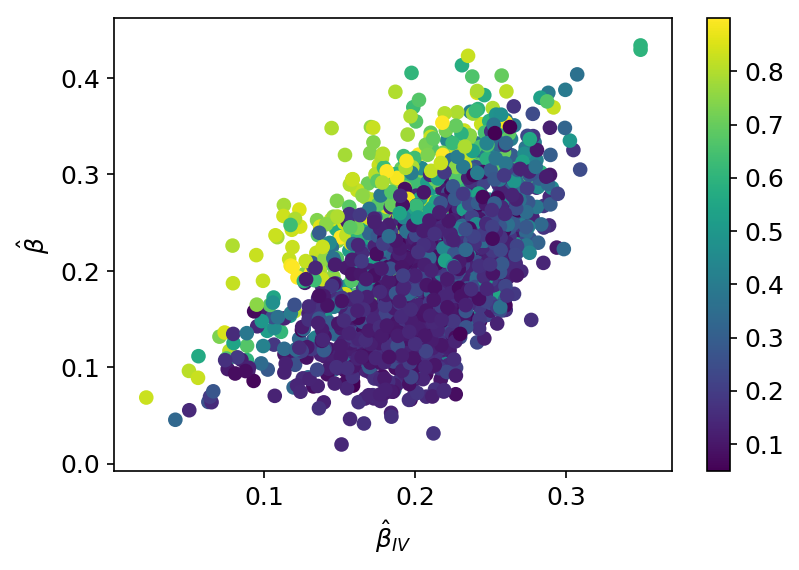

In [24]:
scatterplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

Text(0,0.5,'True weight')

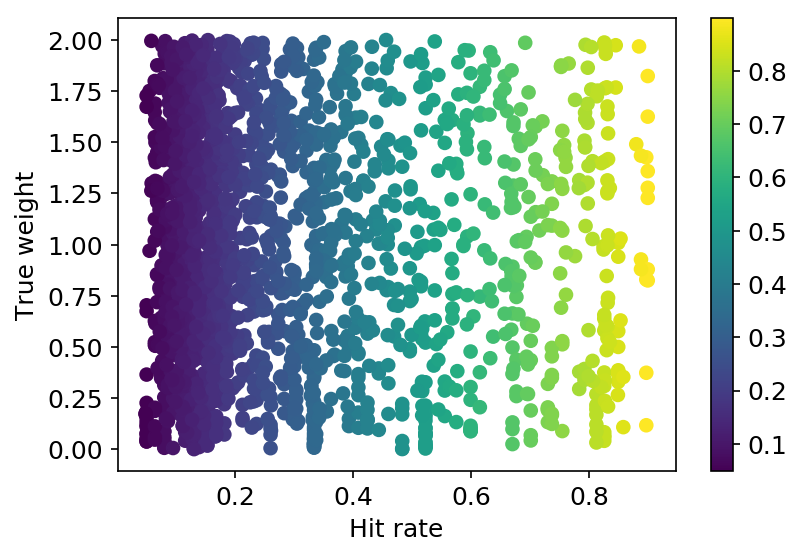

In [25]:
scatterplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Hit rate')
plt.ylabel('True weight')

Text(0,0.5,'True weight')

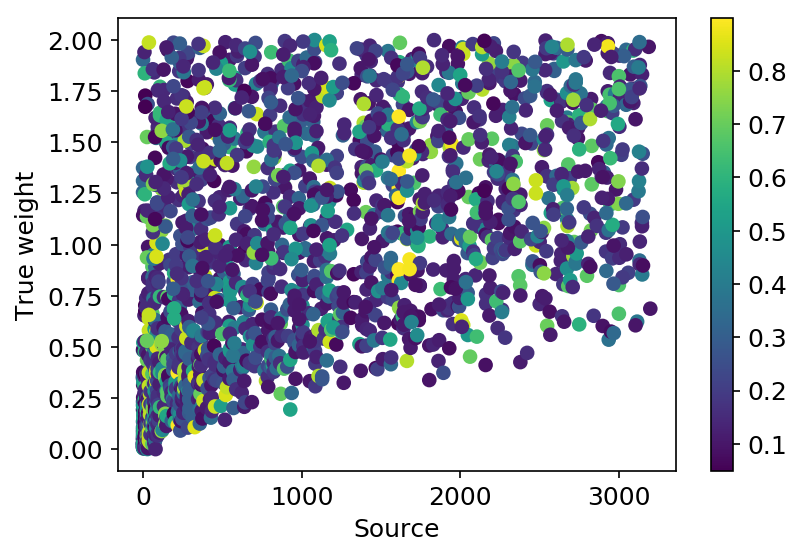

In [26]:
scatterplot(
    'source', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)


plt.xlabel('Source')
plt.ylabel('True weight')

Text(0,0.5,'$\\hat{\\beta}_{IV}$')

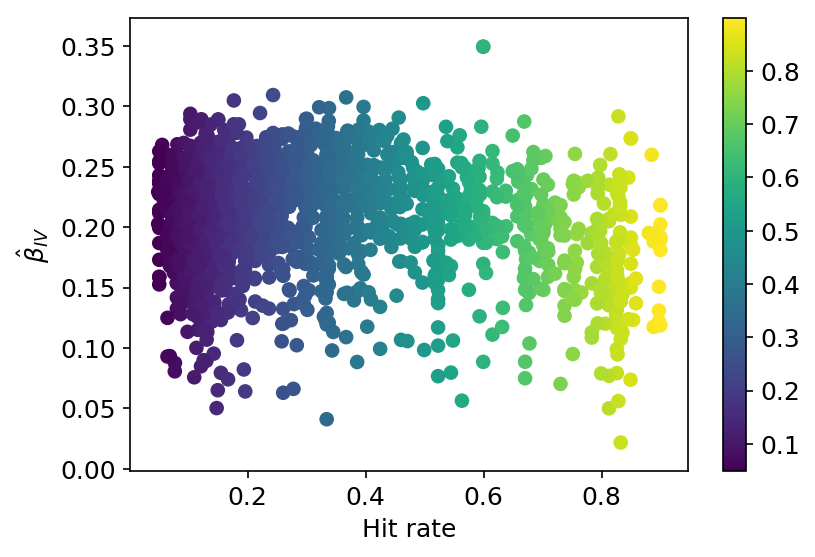

In [27]:
scatterplot(
    'hit_rate', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')

Text(0,0.5,'$\\hat{\\beta}$')

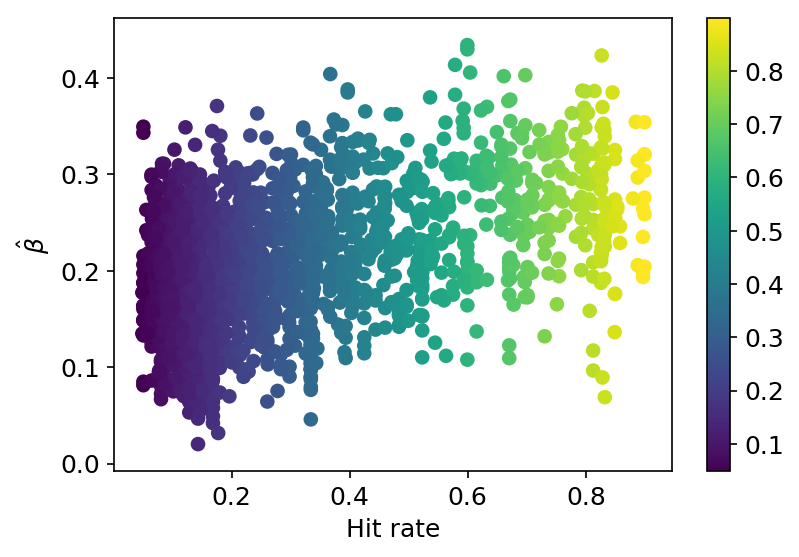

In [28]:
scatterplot(
    'hit_rate', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

Text(0.5,0,'Stimulation amplitude')

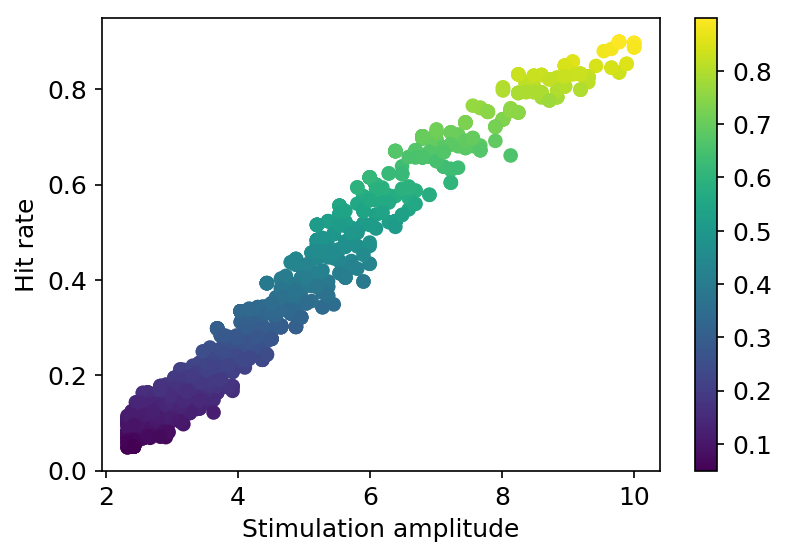

In [29]:
model = scatterplot(
    'stim_amp_source', 'hit_rate', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

plt.ylabel(r'Hit rate')
plt.xlabel(r'Stimulation amplitude')

# zero weight

In [30]:
N = 200
query = 'weight < 0.01 and weight >= 0 and not target_stimulated and target in @sender_ids and stim_amp_source > 1'
sample_zero = conn.query(query)

In [31]:
sample_zero = sample_zero.sample(2000)

In [32]:
result_zero = sample_zero.join(parall_apply(sample_zero, apply))

([<matplotlib.axis.XTick at 0x7f7f1fe79940>,
 <a list of 2 Text xticklabel objects>)

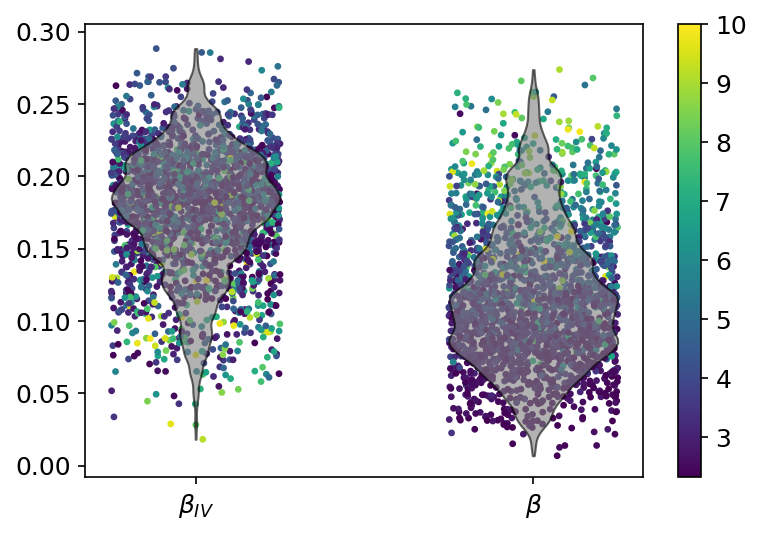

In [33]:
fig, ax = plt.subplots(1, 1)
pos = np.random.uniform(.25,.75, size=len(result_zero))
ax.scatter(pos + .5, result_zero.beta_iv, c=result_zero.stim_amp_source, s=5)
sc = ax.scatter(pos + 1.5, result_zero.beta, c=result_zero.stim_amp_source, s=5)

cb = plt.colorbar(mappable=sc, ax=ax)
cb.ax.yaxis.set_ticks_position('right')

violins = plt.violinplot(result_zero.loc[:, ['beta_iv', 'beta']].T, showextrema=False, bw_method=0.1)
for pc in violins['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])